# Introduction

This notebook will assign documents to domains in the data-driven ontology with the highest Dice similarity of their brain structures and mental function terms.

# Load the data

In [1]:
import pandas as pd
import numpy as np
from partition import *

## Brain activation coordinates

In [2]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [3]:
dtm_bin = load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [4]:
from collections import OrderedDict

In [5]:
lists, circuits = load_framework("data-driven")

In [6]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [7]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=228, Domain N=7


# Assign documents to domains

In [8]:
from scipy.spatial.distance import dice, cdist

In [9]:
pmids = [pmid for pmid in dtm_bin.index if pmid in act_bin.index]
len(pmids)

18155

In [10]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [11]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,addiction,anticipation,arousal,articulation,attention,audition,auditory_feedback,auditory_perception,autobiographical_memory,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


In [12]:
dom_dists = cdist(docs.values, archetypes.values.T, metric="dice")
dom_dists.shape

(18155, 7)

In [13]:
doc2dom = {pmid: 0 for pmid in pmids}
for i, pmid in enumerate(pmids):
    doc2dom[pmid] = np.argmin(dom_dists[i,:]) + 1

In [14]:
doc2dom_df = pd.Series(doc2dom)
doc2dom_df.to_csv("data/doc2dom_data-driven.csv", header=False)

# Plot document distances

In [15]:
%matplotlib inline

In [16]:
doc_dists = cdist(docs, docs, metric="dice")
doc_dists = pd.DataFrame(doc_dists, index=pmids, columns=pmids)

In [17]:
dom_pmids = []
for dom in range(len(domains)):
    dom_pmids += [pmid for pmid, sys in doc2dom.items() if sys == dom + 1]

In [18]:
doc_dists = doc_dists[dom_pmids].loc[dom_pmids]

In [19]:
transitions = []
for i, pmid in enumerate(dom_pmids):
    if doc2dom[dom_pmids[i-1]] != doc2dom[pmid]:
        transitions.append(i)

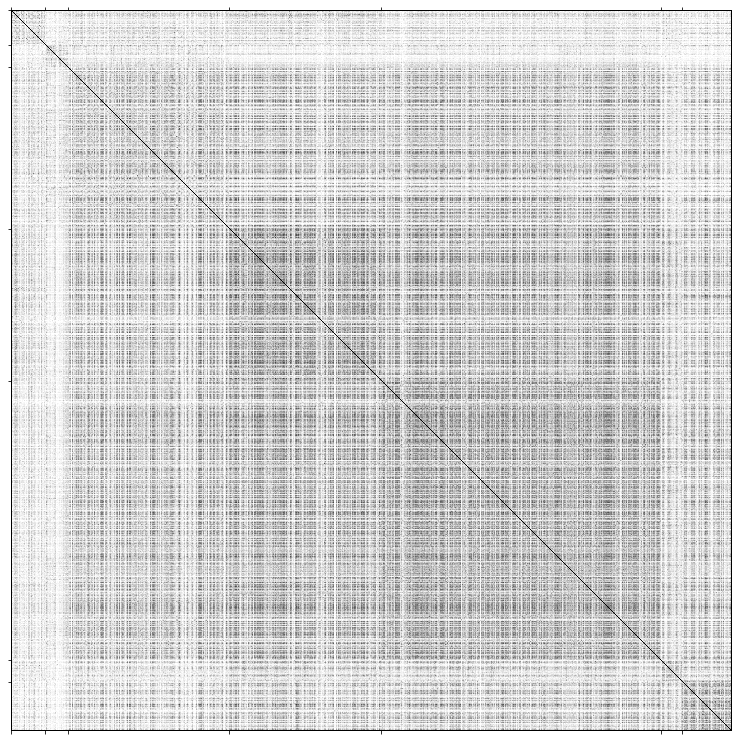

In [20]:
plot_partition("data-driven", doc_dists, transitions)